In [13]:
from pystan import StanModel

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [15]:
#read matches from CSV, data set called df
df = pd.read_csv('matches.csv')
df.head()

,home_team,away_team,home_score,away_score
0,AFC Eskilstuna,Hammarby,0,0
1,Sundsvall,Kalmar,1,3
2,Örebro,Hammarby,0,3
3,IFK Göteborg,Häcken,1,1
4,Sirius,IFK Norrköping,0,1


In [16]:
teams = list(set(df.home_team)) #get a list of the team names, set gives all unique values
team_ids = {team: count+1 for count, team in enumerate(teams)}

In [17]:
#a dictionary, M: number of matches, N: number of teams
data = {'N': len(teams), 'M': len(df)} 

In [18]:
x = df.replace(team_ids)
data.update(df.replace(team_ids))
footballmatch_data = data
#footballmatch_data


In [19]:
df_new=pd.read_csv('upcoming.csv')

In [20]:
new_data = df_new.replace(team_ids)
new_data.rename(columns={'home_team': 'home_team_new', 'away_team': 'away_team_new'}, inplace=True)

In [21]:
new_data
new_data.head()

,home_team_new,away_team_new
0,1,10
1,16,9
2,4,2
3,14,12
4,6,8


In [22]:
upcoming_data = {'M_new':len(new_data)}
#upcoming_data

In [23]:
upcoming_data.update(new_data)
#upcoming_data

In [24]:
#define the model
stan_code_2 = """
data { //everything here in the data block, has to be passed in as mapping/dictionary
  int<lower=1> N; //number of teams
  int<lower=1> M; // set the boundry of the value M, number of games
  int<lower=1, upper=N> home_team[M];//for each match, home_team contains the ID of the home team, the team ID has the boundry
  int<lower=1, upper=N> away_team[M];
  int<lower=0> home_score[M];//boundry is just sanity check, score has to be greater than 0.
  int<lower=0> away_score[M];//for each match, away_score contains the score of the away team.
  // new data used to predict
  int<lower=1> M_new;
  int<lower=1, upper=N> home_team_new[M_new];
  int<lower=1, upper=N> away_team_new[M_new];// home_score_new and away_score_new are what I want to predict
}
parameters {
  real avg;//log of the average goals a team would score in a match. If I have information about the team, this is what my expected value for the goals.
  real home_adv;//a constant value for all teams. the advantage when a team plays at home.
  //everything is in log space, because we define poission_log in the later stage. If it is not log, we'll have do products.
  real off[N]; //offensive ability
  real def[N];//defensive ability, boundry can be defined here. There will be a tranformation. 
  //HMC has to work with unbounded parameters, Stan helps to transfer unbounded to bounded paramter under the hood. But here we don't have to care.
}
model {
//prior
  avg ~ normal(0, 1);
  home_adv ~ normal(0, 1);
  off ~ normal(0, 0.5);
  def ~ normal(0, 0.5);
  
  //likelihood, my score follows poission distribution with lambda(home) and lambda(away)
  //lambda(home) and lambda(away) is actually constructed by 4 factors, they are our parameters
  //since lambda has to be greater than 0, we take the exponential function.
  for (m in 1:M) {
    home_score[m] ~ poisson_log(
      avg + home_adv + off[home_team[m]] - def[away_team[m]]
    );
    away_score[m] ~ poisson_log(
      avg - home_adv + off[away_team[m]] - def[home_team[m]]
    );
  }
}
generated quantities{
int home_score_new[M_new];
int away_score_new[M_new];
//for each sample, I generate one value using the samples as the values for my parameter.
  for (m in 1:M_new) {
    home_score_new[m] = poisson_log_rng(
      avg + home_adv + off[home_team[m]] - def[away_team[m]]
    );
    away_score_new[m] = poisson_log_rng(
      avg - home_adv + off[away_team[m]] - def[home_team[m]]
    );
  }

}
"""

In [25]:
%%time
#compile the model
m_predict = StanModel(model_code=stan_code_2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_79d4bcd7af2497c5bb7b3969fcb6d7db NOW.


CPU times: user 4.42 s, sys: 750 ms, total: 5.17 s
Wall time: 3min 22s


In [26]:
footballmatch_data.update(upcoming_data)
#footballmatch_data

In [27]:
%%time
fit_new = m_predict.sampling(data=footballmatch_data, iter = 20000, chains = 4)
#fit_new contains all samples

CPU times: user 438 ms, sys: 56.1 s, total: 56.5 s
Wall time: 1min 31s


In [28]:
fit_new

Inference for Stan model: anon_model_79d4bcd7af2497c5bb7b3969fcb6d7db.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
avg                  0.17  1.9e-3   0.18  -0.18   0.04   0.16   0.29   0.52   8799    1.0
home_adv             0.11  2.5e-4   0.05   0.01   0.07   0.11   0.14    0.2  40000    1.0
off[0]              -0.08  1.1e-3   0.22  -0.52  -0.23  -0.07   0.07   0.35  40000    1.0
off[1]               0.08  1.1e-3   0.21  -0.35  -0.07   0.08   0.22   0.49  40000    1.0
off[2]              -0.28  1.2e-3   0.24  -0.76  -0.44  -0.28  -0.12   0.17  40000    1.0
off[3]               0.06  1.1e-3   0.21  -0.36  -0.08   0.07   0.21   0.47  40000    1.0
off[4]               0.04  1.1e-3   0.22   -0.4  -0.11   0.04   0.19   0.46  40000    1.0
off[5]               0.35  1.0e-3    0.2  -0.05   0.22   0.36   0.49   0.74  40000    1

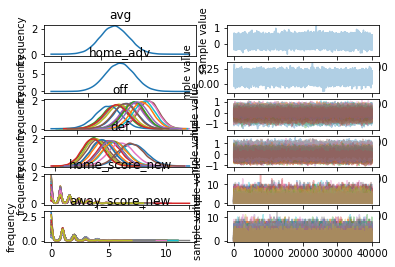

In [30]:
figure = fit_new.traceplot()

In [31]:
samples = fit_new.extract(permuted=True)
#gives all samples

In [32]:
#to operate each row from a table
class TableRow:
    def __init__(self, points=0, goals_for=0, goals_against=0):
        self.points = 0
        self.goals_for = 0
        self.goals_against = 0
    #why define a property? You don't need to write tablerow.score_diff(),now you can just tablerow.score_diff.
    #To have the same way as to call other variables, for example, tablerow.points
    @property
    def score_diff(self):
        return self.goals_for - self.goals_against
    #
    #__lt__ tells python howto use comparison operators, if <, return ture.
    def __lt__(self, other):
        if self.points != other.points:
            return self.points < other.points
        if self.score_diff != other.score_diff:
            return self.score_diff < other.score_diff
        return self.goals_for < other.goals_for
    #equality
    def __eq__(self, other):
        return not (self > other or self < other)
    
    #how to represent as a string, mainly for debug
    def __repr__(self):
        return f"TableRow({self.points}, {self.goals_for}, {self.goals_against})"

In [33]:
from collections import defaultdict

In [34]:
#creates a new empty discionary
#instead of raising KeyErrors, it inserts the key
#TableRow is the factory function, it tells you how to create new objects for a dictionary.
#if I put int, I will get zero.
#everything is an object in Python.
table_rows = defaultdict(TableRow)

In [35]:
#df is the passed games, with home score and away score
#how are we using the TableRow class?
#feed the data
for row in df.itertuples():
    home_points = 3*(row.home_score > row.away_score) + (row.home_score == row.away_score)
    away_points = 3*(row.away_score > row.home_score) + (row.home_score == row.away_score)
    table_rows[row.home_team].points += home_points
    table_rows[row.home_team].goals_for += row.home_score
    table_rows[row.home_team].goals_against += row.away_score
    table_rows[row.away_team].points += away_points
    table_rows[row.away_team].goals_for += row.away_score
    table_rows[row.away_team].goals_against += row.home_score

In [36]:
table_rows

defaultdict(__main__.TableRow,
            {'AFC Eskilstuna': TableRow(12, 18, 37),
             'AIK': TableRow(35, 24, 14),
             'Djurgården': TableRow(36, 35, 21),
             'Elfsborg': TableRow(27, 37, 31),
             'Halmstad': TableRow(13, 19, 29),
             'Hammarby': TableRow(29, 30, 25),
             'Häcken': TableRow(32, 23, 15),
             'IFK Göteborg': TableRow(29, 30, 24),
             'IFK Norrköping': TableRow(33, 27, 25),
             'Jönköping': TableRow(19, 20, 34),
             'Kalmar': TableRow(20, 18, 35),
             'Malmö FF': TableRow(46, 38, 18),
             'Sirius': TableRow(33, 32, 22),
             'Sundsvall': TableRow(16, 15, 29),
             'Örebro': TableRow(27, 26, 33),
             'Östersund': TableRow(29, 27, 27)})

In [117]:
#the comparison operator is used in sorted function
#played_games_points = [*sorted(table_rows.items(), key=lambda x: x[1], reverse=True)] 
#how does it work, does it sort by first number, second number and last number? Yes, where did we creae this criteria?

In [37]:
#40000 samples, each sample has 79 up coming games
df_new_predicted = df_new.assign(home_score = samples['home_score_new'][0],away_score = samples['away_score_new'][0])
df_new_predicted

,home_team,away_team,away_score,home_score
0,AIK,Djurgården,3.0,1.0
1,Häcken,Jönköping,1.0,1.0
2,IFK Norrköping,Östersund,0.0,0.0
3,Kalmar,Sirius,2.0,1.0
4,Elfsborg,Halmstad,0.0,0.0
5,Malmö FF,IFK Göteborg,2.0,0.0
6,Sundsvall,Örebro,0.0,1.0
7,Östersund,AFC Eskilstuna,3.0,1.0
8,Elfsborg,Kalmar,4.0,1.0
9,Halmstad,Häcken,2.0,1.0


In [38]:
from copy import deepcopy

In [39]:
#loop each iteration (2000 iterations)
#define a function to produce a table
def produce_ordered_predicted_table(dataframe):
    copied_played_games_points = deepcopy(table_rows)
    for row in dataframe.itertuples():
        home_points = 3*(row.home_score > row.away_score) + (row.home_score == row.away_score)
        away_points = 3*(row.away_score > row.home_score) + (row.home_score == row.away_score)
        copied_played_games_points[row.home_team].points += home_points
        copied_played_games_points[row.home_team].goals_for += row.home_score
        copied_played_games_points[row.home_team].goals_against += row.away_score
        copied_played_games_points[row.away_team].points += away_points
        copied_played_games_points[row.away_team].goals_for += row.away_score
        copied_played_games_points[row.away_team].goals_against += row.home_score
    sorted_table = [*sorted(copied_played_games_points.items(), key=lambda x: x[1], reverse=True)]
    return sorted_table
    

In [144]:
test_table = produce_ordered_predicted_table(df_new_predicted)

In [40]:
%%time
win_counts = defaultdict(int)
qualified_counts = defaultdict(int)
relegated_counts = defaultdict(int)
#make another table to calculate the probability for the 1st place, 3rd place, kick-out place (sum up the last 2 rows)
for i in range(40000):
    df_new_predicted = df_new.assign(home_score = samples['home_score_new'][i],away_score = samples['away_score_new'][i])
    test_table = produce_ordered_predicted_table(df_new_predicted)
    win_counts[test_table[0][0]] += 1
    qualified_counts[test_table[-3][0]] += 1
    relegated_counts[test_table[-2][0]] += 1
    relegated_counts[test_table[-1][0]] += 1
print(win_counts)
print(qualified_counts)
print(relegated_counts)

    

defaultdict(<class 'int'>, {'Malmö FF': 36718, 'AIK': 302, 'Djurgården': 2581, 'Häcken': 63, 'IFK Norrköping': 134, 'Sirius': 169, 'IFK Göteborg': 19, 'Östersund': 9, 'Hammarby': 4, 'Elfsborg': 1})
defaultdict(<class 'int'>, {'Jönköping': 9862, 'AFC Eskilstuna': 9433, 'Halmstad': 4775, 'Kalmar': 4683, 'Sundsvall': 10580, 'Elfsborg': 232, 'Hammarby': 84, 'Örebro': 290, 'IFK Göteborg': 20, 'Östersund': 28, 'Häcken': 10, 'IFK Norrköping': 3})
defaultdict(<class 'int'>, {'AFC Eskilstuna': 22209, 'Halmstad': 32352, 'Jönköping': 8885, 'Sundsvall': 13836, 'Kalmar': 2602, 'Elfsborg': 40, 'Hammarby': 14, 'Örebro': 54, 'IFK Göteborg': 5, 'Östersund': 2, 'Häcken': 1})
CPU times: user 8min 43s, sys: 4.27 s, total: 8min 47s
Wall time: 8min 50s


In [41]:
final_all = [win_counts,qualified_counts,relegated_counts]

In [42]:
final_all_df = pd.DataFrame(final_all, index=['win', 'qualified','relegated']).T.fillna(0)
final_all_df

,win,qualified,relegated
AFC Eskilstuna,0.0,9433.0,22209.0
AIK,302.0,0.0,0.0
Djurgården,2581.0,0.0,0.0
Elfsborg,1.0,232.0,40.0
Halmstad,0.0,4775.0,32352.0
Hammarby,4.0,84.0,14.0
Häcken,63.0,10.0,1.0
IFK Göteborg,19.0,20.0,5.0
IFK Norrköping,134.0,3.0,0.0
Jönköping,0.0,9862.0,8885.0
